# package & connecting to drive

In [ ]:
''' Step 1 '''
# Import packages
from torch.utils.data import Dataset
import torch
import numpy as np
from pycocotools.coco import COCO
import os

from PIL import Image
import matplotlib.pyplot as plt
import cv2
# import ...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setting Data


In [ ]:
''' Step 2 '''
# Build dataset using pycocotools api
class FaceMaskDataset(Dataset):
  def __init__(self, json_path,img_path,transforms):
    self.coco = COCO(json_path)
    self.image_ids = list(self.coco.imgToAnns.keys())
    self.img_path = img_path
    self.transforms = transforms
  def __len__(self):
  # ....
    return len(self.image_ids)


  def __getitem__(self, idx):
  # ....
    image_id = self.image_ids[idx]
    file_name = self.coco.loadImgs(image_id)[0]['file_name']
    file_name = os.path.join(self.img_path, file_name)
    image = Image.open(file_name).convert('RGB')
    annot_ids = self.coco.getAnnIds(imgIds=image_id) # call annotation ids by using image_id
    annots = [x for x in self.coco.loadAnns(annot_ids)
    if x['image_id'] == image_id] # call annotations by using annotation id



    # convert bounding box (x, y, w, h) -> (x1, y1, x2, y2)
    boxes = np.array([annot['bbox'] for annot in annots], dtype=np.float32)
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

    labels = np.array([annot['category_id'] for annot in annots], dtype=np.int32) # class ID of the object
    # masks = np.array([self.coco.annToMask(annot) for annot in annots], dtype=np.uint8) # For segmentation task

    area = np.array([annot['area'] for annot in annots], dtype=np.float32) # number of pixels inside segmentation mask
    iscrowd = np.array([annot['iscrowd'] for annot in annots], dtype=np.uint8) #  whether the annotation is for the single object (0) or for the multiple objects

    target = {
            'image_id': image_id,
            'boxes': boxes,
            # 'masks': masks,# For segmentation task
            'labels': labels,
            'area': area,
            'iscrowd': iscrowd}

    # convert numpy array to torch tensor and define data type of tensor
    target["image_id"] = torch.as_tensor(target['image_id'], dtype=torch.uint8)
    target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
    # target['masks'] = torch.as_tensor(target['masks'], dtype=torch.uint8) # For segmentation task
    target['labels'] = torch.as_tensor(target['labels'], dtype=torch.int64)
    target['area'] = torch.as_tensor(target['area'], dtype=torch.float32)
    target['iscrowd'] = torch.as_tensor(target['iscrowd'], dtype=torch.uint8)
    if self.transforms is not None:
      image, target = self.transforms(image, target)

    return image, target
    # return image, target
    #return target

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/2022_deep_learning/coding_lecture/05.19.CodingLecture7/vis_utils')
#print(sys.path)
import utils
from engine import *
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset
import transforms as T

In [ ]:
''' Step 3 '''
# Build dataloader for train, validation and test dataset
def get_transform(train):
    # from torchvision.transforms import transforms as Tr
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

# Define collate_fn
def collate_fn(batch):
    return tuple(zip(*batch))

# For instance,
batch_size =  2

# Train
json_path =  '/content/drive/MyDrive/Baseline/Data/Train.json'
img_path =  '/content/drive/MyDrive/train_data/images'
train_dataset = FaceMaskDataset(json_path,img_path,get_transform(train=True))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn = collate_fn)
print(train_dataloader)
# Test
#json_pathV =  '/content/drive/MyDrive/2022_deep_learning/coding_lecture/Homework/HW03/FaceMask_Detection_Dataset/coco_json/val.json'
#img_pathV =  '/content/drive/MyDrive/2022_deep_learning/coding_lecture/Homework/HW03/FaceMask_Detection_Dataset/images'
#train_datasetV = FaceMaskDataset(json_pathV,img_pathV,get_transform(train=False))
#train_dataloaderV = torch.utils.data.DataLoader(train_datasetV, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn = collate_fn)


# Validation
json_pathT =  '/content/drive/MyDrive/Baseline/Data/Train.json'
img_pathT =  '/content/drive/MyDrive/train_data/images'
train_datasetT = FaceMaskDataset(json_pathT,img_pathT,get_transform(train=False))
train_dataloaderT = torch.utils.data.DataLoader(train_datasetT, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn = collate_fn)

#for a,b in train_dataloader:
#    print("a",a)
#    print("b",b)
    #print("c",c)
    #rint("d",d)
    #print("e",e)


loading annotations into memory...
Done (t=2.29s)
creating index...
index created!
loading annotations into memory...
Done (t=1.14s)
creating index...
index created!


# lode the model

In [ ]:
''' Step 1 '''
# Load model for object detection
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model  = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
''' Step 2 '''
# Modify the architecture of model to fit our data
# !Notice! Number of the class of the dataset is three, but we have to consider that we need one more class for "background(0)"
num_classes = 15 # (object + background)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Training

In [ ]:
''' Step 1 '''
# Define hyper-parameters for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

params = [p for p in model.parameters() if p.requires_grad] # call model's parameters that require update of gradient

optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

num_epochs = 4
# device =
# optimizer =
# lr_scheduler =
# ....


In [ ]:
''' Step 2 '''
# Define function for training
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    # Record Learning rate
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    print(header)
    print(print_freq)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        #print(images)
        #print(targets)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # Record Losses
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        # Sum each values of losses
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

In [ ]:
import os
import numpy as np
import torch
from PIL import Image

In [ ]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    torch.save(model.state_dict(), f'/content/drive/MyDrive/objectdetection_{epoch}.pth')

Epoch: [0]
10
Epoch: [0]  [    0/12322]  eta: 17 days, 12:12:42  lr: 0.000010  loss: 3.5522 (3.5522)  loss_classifier: 2.8547 (2.8547)  loss_box_reg: 0.6256 (0.6256)  loss_objectness: 0.0522 (0.0522)  loss_rpn_box_reg: 0.0196 (0.0196)  time: 122.7692  data: 115.3399  max mem: 2508
Epoch: [0]  [   10/12322]  eta: 1 day, 15:55:14  lr: 0.000060  loss: 3.3959 (3.3628)  loss_classifier: 2.7970 (2.7559)  loss_box_reg: 0.5673 (0.5395)  loss_objectness: 0.0463 (0.0522)  loss_rpn_box_reg: 0.0122 (0.0152)  time: 11.6727  data: 10.4977  max mem: 2772
Epoch: [0]  [   20/12322]  eta: 21:49:03  lr: 0.000110  loss: 3.1033 (2.9597)  loss_classifier: 2.4496 (2.3846)  loss_box_reg: 0.5265 (0.5138)  loss_objectness: 0.0394 (0.0484)  loss_rpn_box_reg: 0.0087 (0.0129)  time: 0.5654  data: 0.0138  max mem: 2772
Epoch: [0]  [   30/12322]  eta: 15:23:35  lr: 0.000160  loss: 2.0834 (2.5697)  loss_classifier: 1.4101 (1.9511)  loss_box_reg: 0.5265 (0.5570)  loss_objectness: 0.0340 (0.0492)  loss_rpn_box_reg: 0.0

In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/objectdetection_{epoch}.pth')

NameError: ignored

In [ ]:
''' Step 3 '''
# Define function for evaluation


' Step 3 '

# evaluation

In [ ]:
import sys
sys.path.append('//content/drive/MyDrive/2022_deep_learning/coding_lecture/05.19.CodingLecture7/vis_utils')
import utils
from engine import *

def evaluate(model, data_loader, device):
    # FIXME remove this and make paste_masks_in_image run on the GPU
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = ["bbox"]
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)
    # gather the stats from all processes
    print("Averaged stats:", metric_logger)

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    return coco_evaluator

# detection

## video -> image

In [ ]:
import cv2
import os

In [ ]:
filepath = '/content/drive/MyDrive/test_data/Test.mp4'
video = cv2.VideoCapture(filepath) #'' 사이에 사용할 비디오 파일의 경로 및 이름을 넣어주도록 함

if not video.isOpened():
    print("Could not Open :", filepath)
    exit(0)

length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)

print("length :", length)
print("width :", width)
print("height :", height)
print("fps :", fps)

try:
    if not os.path.exists(filepath[:-4]):
        os.makedirs(filepath[:-4])
except OSError:
    print ('Error: Creating directory. ' +  filepath[:-4])





length : 125
width : 1280
height : 720
fps : 25.0


In [ ]:
count = 0
new_fps = fps
fps = 50
while(video.isOpened()):
    if int(video.get(1)) + fps > length:
      break
    ret, image = video.read()
    if(int(video.get(1)) % fps == 0): #앞서 불러온 fps 값을 사용하여 1초마다 추출
        if int(video.get(1)) + fps > length:
          break
        cv2.imwrite(filepath[:-4] + "/frame%d.jpg" % count, image)
        print('Saved frame number :', str(int(video.get(1))))
        count += 1

video.release()

Saved frame number : 50


## image -> tensor

In [ ]:
# Import required libraries
import torch
import cv2
import torchvision.transforms as transforms

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# Read the image
#image = cv2.imread('/content/drive/MyDrive/train_data/images/20210112_경상남도_창원시_-_맑음_주간_실외_right_0194949.png')

# Convert BGR image to RGB image
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_tensor = []
for i in range(count):
  file_name = f'/content/drive/MyDrive/test_data/Test/frame{i}.jpg'


  image = Image.open(file_name).convert('RGB')



  # Define a transform to convert
  # the image to torch tensor
  transform = transforms.Compose([
      transforms.ToTensor()
  ])

  # Convert the image to Torch tensor
  img_tensor.append(transform(image))

  # print the converted image tensor
  #print(img_tensor)


## detection

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


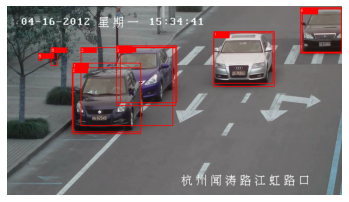

"\nidxs = [0,1,2,3,4] ## Modify here\nfor idx in idxs:\n  img, _ = train_datasetT[idx] \n  model.eval() \n  with torch.no_grad(): \n      prediction = model([img.to(device)])\n  results = overlay_instances(img, prediction, threshold=0.3) \n  plt.axis('off')\n  plt.imshow(results)\n  plt.show() \n  #plt.savefig('')\n"

In [ ]:
''' Step 6 '''
def overlay_instances(img, prediction, threshold=0.8):
    label_dict = {0 : '0', 1: '1',2 : '2',3 : '3',4 : '4', 5: '5',6 : '6',7 : '7',8 : '8', 9: '9',10 : '10',11 : '11', 12: '12',13: '13',14: '14'}
    ori_img = img.mul(255).permute(1,2,0).byte().numpy() # Tensor * 255, Convert RGB -> BGR, Tensor to numpy
    t_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    for idx in range(len(prediction[0]['boxes'])):
        score = prediction[0]['scores'][idx].cpu().detach().numpy().item() # detach() : Generation of tensors that do not propagate gradients from existing sensors
        if score < threshold:
            continue
        box = x1,y1,x2,y2 = prediction[0]['boxes'][idx].cpu().detach().numpy()

        label = prediction[0]['labels'][idx].cpu().detach().numpy().item()
        #print(x1, y1, x2, y2, label)
        cv2.rectangle(t_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)
        cv2.rectangle(t_img, (int(x1), int(y1)), (int(x1+60), int(y1+20)), (255,0,0), -1)
        cv2.putText(t_img, label_dict[label], (int(x1), int(y1+15)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), thickness=1)
    return Image.fromarray(t_img)
#print(train_datasetT[0])

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 15

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/objectdetection_0.pth', map_location=torch.device('cpu')))
model.eval()

i = 0

for imag_tensor in img_tensor:
  img = imag_tensor
  device = 'cpu'


  with torch.no_grad():
      prediction = model([img.to(device)])
  #print(prediction)

  results = overlay_instances(img, prediction, threshold=0.3)

  plt.axis('off')
  plt.imshow(results)
  plt.savefig(f'/content/drive/MyDrive/test_data/Test/frame{i}.jpg')
  plt.show()
  i += 1

'''
idxs = [0,1,2,3,4] ## Modify here
for idx in idxs:
  img, _ = train_datasetT[idx]
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])
  results = overlay_instances(img, prediction, threshold=0.3)
  plt.axis('off')
  plt.imshow(results)
  plt.show()
  #plt.savefig('')
'''

## image -> video

In [ ]:
import re
path = "/content/drive/MyDrive/test_data/Test"
paths = [os.path.join(path , i ) for i in os.listdir(path) if re.search(".jpg$", i )]

len(paths)

61

In [ ]:
pathIn= '/content/drive/MyDrive/test_data/Test'
pathOut = '/content/drive/MyDrive/test_data/Test/test.mp4'
fps = new_fps# // 4
import cv2
frame_array = []
for idx , path in enumerate(paths) :
    if (idx % 2 == 0) | (idx % 5 == 0) :
        continue
    img = cv2.imread(path)
    height, width, layers = img.shape
    size = (width,height)
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

# 연습장

## tem

In [ ]:
''' Step 2 '''
# Build dataset using pycocotools api
class FaceMaskTestDataset(Dataset):
  def __init__(self,img_path,transform):
    #self.coco = COCO(json_path)
    #self.image_ids = list(self.coco.imgToAnns.keys())
    self.img_path = "/content/drive/MyDrive/train_data/images"
    self.transform = transform
  def __len__(self):
  # ....
    return 1


  def __getitem__(self, idx):
  # ....
    #image_id = self.image_ids[idx]
    #file_name = self.coco.loadImgs(image_id)[0]['file_name']
    file_name = os.path.join(self.img_path, "20210112_경상남도_창원시_-_맑음_주간_실외_right_0194949.png")
    image = Image.open(file_name).convert('RGB')
    #annot_ids = self.coco.getAnnIds(imgIds=image_id) # call annotation ids by using image_id
    #annots = [x for x in self.coco.loadAnns(annot_ids)
    #if x['image_id'] == image_id] # call annotations by using annotation id



    # convert bounding box (x, y, w, h) -> (x1, y1, x2, y2)
    #boxes = np.array([annot['bbox'] for annot in annots], dtype=np.float32)
    #boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    #boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

    #labels = np.array([annot['category_id'] for annot in annots], dtype=np.int32) # class ID of the object
    # masks = np.array([self.coco.annToMask(annot) for annot in annots], dtype=np.uint8) # For segmentation task

    #area = np.array([annot['area'] for annot in annots], dtype=np.float32) # number of pixels inside segmentation mask
    #iscrowd = np.array([annot['iscrowd'] for annot in annots], dtype=np.uint8) #  whether the annotation is for the single object (0) or for the multiple objects

   # target = {
            #'image_id': image_id,
            #'boxes': boxes,
            # 'masks': masks,# For segmentation task
            #'labels': labels,
            #'area': area,
            #'iscrowd': iscrowd}

    # convert numpy array to torch tensor and define data type of tensor
    #target["image_id"] = torch.as_tensor(target['image_id'], dtype=torch.uint8)
    #target['boxes'] = torch.as_tensor(target['boxes'], dtype=torch.float32)
    # target['masks'] = torch.as_tensor(target['masks'], dtype=torch.uint8) # For segmentation task
    #target['labels'] = torch.as_tensor(target['labels'], dtype=torch.int64)
    #target['area'] = torch.as_tensor(target['area'], dtype=torch.float32)
    #target['iscrowd'] = torch.as_tensor(target['iscrowd'], dtype=torch.uint8)
    #transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
    transform = transforms.Compose([
    transforms.ToTensor()
      ])
    image = transform(image)

    return image
img_path =  "/content/drive/MyDrive/train_data/images"
def collate_fn(batch):
    return tuple(zip(*batch))
def get_transform(train):
    # from torchvision.transforms import transforms as Tr
    transform = []
    transform.append(T.ToTensor())
    return T.Compose(transform)

train_datasetT = FaceMaskTestDataset(img_path,get_transform(train=True))
train_dataloaderT = torch.utils.data.DataLoader(train_datasetT, batch_size=1, shuffle=True, num_workers=1, collate_fn = collate_fn)

## 실시간 코드


In [ ]:
#!/usr/bin/python3

# ------------------------------------------------------------------------------
# Display the image captured from the camera. Used as a test program to verify if OpenCV has been properly installed.
# ------------------------------------------------------------------------------
# automaticdai
# YF Robotics Labrotary
# Instagram: yfrobotics
# Twitter: @yfrobotics
# Website: https://www.yfrl.org
# ------------------------------------------------------------------------------

import cv2

CAMERA_DEVICE_ID = 0
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 240

if __name__ == "__main__":
    try:
        # create video capture
        cap = cv2.VideoCapture(CAMERA_DEVICE_ID)

        # set resolution to 320x240 to reduce latency
        cap.set(3, IMAGE_WIDTH)
        cap.set(4, IMAGE_HEIGHT)

        # Loop to continuously get images
        while True:
            # Read the frames from a camera
            _, frame = cap.read()

            # show image
            cv2.imshow('frame', frame)

            # if key pressed is 'Esc' then exit the loop
            if cv2.waitKey(33) == 27:
                break
    except Exception as e:
        print(e)
    finally:
        # Clean up and exit the program
        cv2.destroyAllWindows()
        cap.release()

cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow



In [ ]:
import cv2

# ------------------------------------------------------------------------------
# automaticdai
# YF Robotics Labrotary
# Instagram: yfrobotics
# Twitter: @yfrobotics
# Website: https://www.yfrl.org
# ------------------------------------------------------------------------------
# Reference:
# - https://towardsdatascience.com/face-detection-in-2-minutes-using-opencv-python-90f89d7c0f81
# ------------------------------------------------------------------------------

# Load the cascade
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/haarcascade_frontalface_default.xml')

# To capture video from webcam.
cap = cv2.VideoCapture(0)
# To use a video file as input
# cap = cv2.VideoCapture('filename.mp4')

while True:
    # Read the frame
    _, img = cap.read()
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect the faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    # Draw the rectangle around each face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
    # Display
    cv2.imshow('img', img)
    # Stop if escape key is pressed
    k = cv2.waitKey(30) & 0xff
    if k==27:
        break

# Release the VideoCapture object
cap.release()

error: ignored